# Initial state estimation with Minor Planet Center Observations
Copyright (c) 2010-2023, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example highlights a simple orbit estimation routine using real, angular observation data from the  [Minor Planet Center](https://www.minorplanetcenter.net/) (MPC). We will estimate the initial state of [Ceres](https://en.wikipedia.org/wiki/Ceres_(dwarf_planet)) the largest body in the asteroid belt. We will use the Tudat BatchMPC interface to retrieve and process the data. For a more in depth explanation of this interface first check out the [Retrieving observation data from the Minor Planet Centre example](#) .

## Import statements

In [32]:
# Tudat imports for propagation and estimation
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation

# import MPC interface
from tudatpy.data.mpc import BatchMPC

# other useful modules
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## Preparing the environment and observations

### Loading Spice Kernels.
We use SPICE kernels to retrieve the ephemerides the planets as well as to verify our results for Ceres. The ephemerides for Ceres and other asteroids are not included in Tudat by default but can still be loaded in. The relevant SPICE kernel can be retrieved from NAIF archives [here](https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/asteroids/).

In [33]:
# SPICE KERNELS
spice.load_standard_kernels()
# ephemerides for the asteroids
spice.load_kernel(r"codes_300ast_20100725.bsp")
# time frame information
spice.load_kernel(r"codes_300ast_20100725.tf")

### Retrieving the observations
We retrieve the observation data using the BatchMPC interface. By default all observation data is retrieved, even the first observation from Piazzi in 1801. We filter to only include data between January 2018 and July 2023.

In [34]:
codes = [1]

batch = BatchMPC()
batch.get_observations(codes)
batch.filter(
    epoch_start=datetime.datetime(2018, 1, 1),
    epoch_end=datetime.datetime(2023, 7, 1),
)

batch.summary()


   Batch Summary:
1. Batch includes 1 minor planets:
   ['1']
2. Batch includes 272 observations, including 117 observations from space telescopes
3. The observations range from 2018-01-20 10:01:17.183998 to 2023-06-14 13:23:15.993581
   In seconds TDB since J2000: 569714546.3684946 to 740021065.178199
   In Julian Days: 2458138.91756 to 2460110.057824
4. The batch contains observations from 27 observatories, including 1 space telescopes



Our batch includes many observations from space telescopes, lets take a closer look at that data.

In [35]:
print("Summary of space telescopes in batch:")
print(batch.observatories_table(only_space_telescopes=True))
obs_by_WISE = batch.table.query("observatory == 'C51'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]

print("\nInitial and Final Observations by WISE:")
print(obs_by_WISE)

Summary of space telescopes in batch:
     Code  Name  count
1225  C51  WISE  117.0

Initial and Final Observations by WISE:
     number                   epochUTC        RA       DEC
6467      1 2018-04-03 11:44:59.711984  2.288533  0.539532
6724      1 2023-05-23 17:39:40.896011  3.138465  0.233569


While the observations from WISE appear to be useful, including them requires setting up the dynamics for the WISE spacecraft which is too advanced for this tutorial and its observations will be excluded automatically later on in this example. The observations can also be filtered out explicitly by excluding the observatories with the .filter() method. Note that all the observations are given in an angular format, Right Ascension (RA) and Declination (DEC)/

### Set up the environment
We now set up the environment, including the bodies to use, the reference frame and frame origin. The epherides for all major planets as well as the Earth's Moon are included retrieved using spice. For our frame origin we use the Solar System Barycentre. The data from MPC is presented in the J2000 reference frame, currently BatchMPC does not support conversion to other reference frames and as such we match it in our environment. 

BatchMPC will automatically generate the body object for Ceres, but we still need to specify the bodies to propagate and their central bodies. We can retrieve the list from the BatchMPC object.

In [36]:
# List the bodies for our environment
bodies_to_create = [
    "Sun",
    "Mercury",
    "Venus",
    "Earth",
    "Moon",
    "Mars",
    "Jupiter",
    "Saturn",
    "Uranus",
    "Neptune",
]

# define the frame origin and orientation. 
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve Ceres' body name from BatchMPC and set its centre
bodies_to_propagate = batch.MPC_objects
central_bodies = ["SSB"]

### Convert the observations to Tudat
Now that our system of bodies is ready we can retrieve the observation collection and links from the observations batch. With the links we just need to define the observation settings, this is where you would also add corrections. For the purpose of this example, we will keep it simple and use the plain angular position settings, which can process observations with Right Ascension and Declination. We can also retrieve the times for the first and final observations from the batch object.

In [37]:
# Transform the MPC observations into a tudat compatible format.
observation_collection, links = batch.to_tudat(bodies=bodies)

# set create angular_position settings for each link in the list.
observation_settings_list = list()
for link in list(links.values()):
    observation_settings_list.append(observation.angular_position(link))

# Retrieve the first and final observation epochs
epoch_start = batch.epoch_start
epoch_end = batch.epoch_end

### Creating the acceleration settings
Ceres will be propagated and as such we need to define the settings of the forces acting on it. We will include point mass gravity accelerations for each of the bodies defined before, as well as Schhwarzschild relativistic corrections for the sun. With these accelerations we can generate our acceleration model for the propagation. A more realistic acceleration model will yield better results but this is outside the scope of this example.

In [38]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild = True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only Ceres
acceleration_settings = {}
for body in batch.MPC_objects:
    acceleration_settings[str(body)] = accelerations

# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

### Retrieving an initial guess for Ceres' position
We use the SPICE ephemeris to retrieve a 'benchmark' initial state for Ceres at the final epoch. We can also use this initial state as our initial guess for the estimation. To ensure a working estimation we add a random uniform offset of +/- 1 million kilometers for the position and 100 m/s for the velocity. We take the final time to retrieve the 'latest' position.

In [39]:
# benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch("Ceres", "SSB", "J2000", "NONE", epoch_end)

# Add random offset for initial guess
np.random.seed = 1

initial_guess = initial_states.copy()
initial_guess[0:3] += (2*np.random.rand(3) - 1) * (1e6 * 1000)
initial_guess[3:6] += (2*np.random.rand(3) - 1) * 100

print("Error between initial state and initial guess:")
print(initial_guess - initial_states)

Error between initial state and initial guess:
[ 5.73592764e+08  2.08224026e+08  9.32823362e+08 -3.32149628e+01
 -2.95146012e+01  5.63384925e+01]


### Finalising the propagation setup
In this example we set up the propagation to run in reverse. We set the timestep to minus 20 hours. For the integrator we use the fixed timestep RKF-7(8) setting our initial time to the time of the batch's final observation. We then set the termination to stop at the time of the batch's oldest observation. These two settings are then the final pieces to create our propagation settings. 

In [40]:
# timestep of 20 hours
dt = -(20 * 3600)

# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_end, dt, propagation_setup.integrator.rkf_78, dt, dt, 1.0, 1.0
)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_start)


# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_end,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

## Setting Up the estimation
With the observation collection, the environment and propagations settings ready we can now begin setting up our estimation. 

In this example we will simply estimate the position of Ceres and as such only include an initial states parameter.

In [41]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

The `Estimator` object collects the environment, observation settings and propagation settings. We also create an `EstimationInput` object and provide it our observation collection retrieved from `.to_tudat()` as well as setting the maximum iteration steps to 6.

In [42]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True, 
)

# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=6,
    )
)

# Set methodological options
pod_input.define_estimation_settings(reintegrate_variational_equations=True)

## Performing the estimation and analysing results

With everything set up we can now perform the estimation. 

In [43]:
# Perform the estimation
pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 310
Parameter update-5.83831e+08 -2.01011e+08 -9.82881e+08      34.1538      25.7757     -48.6174
Current residual: 0.0265279
Calculating residuals and partials 310
Parameter update  1.0147e+07 -7.57038e+06  4.99937e+07    -0.931261      3.74211     -7.71093
Current residual: 0.000307697
Calculating residuals and partials 310
Parameter update   -7264.69    -1559.24     15239.1 -0.00207607  0.00147701  0.00124368
Current residual: 4.33959e-06
Calculating residuals and partials 310
Parameter update    0.065218      0.36527    -0.171119 -1.41023e-09 -2.52195e-09 -1.77742e-08
Current residual: 4.11982e-06
Calculating residuals and partials 310
Parameter update  0.00993855  0.000680567  -0.00190828  5.96115e-10  9.74221e-11 -7.36541e-11
Current residual: 4.11982e-06
Calculating residuals and partials 310
Parameter update  0.00246153 -0.000794523 -0.000537749  1.22971e-10  -1.9821e-11 -2.96872e-11
Current residual: 4.11982e-06
Maximum number of iterations r

The estimator appears to converge within 6 steps. Lets check how close our initial and final guesses are compared to the benchmark state.

In [44]:
# retrieve the final estimated state.
results_final = pod_output.parameter_history[:, -1]

vector_error_initial = (np.array(initial_guess) - initial_states)[0:3]
error_magnitude_initial = np.sqrt(np.square(vector_error_initial).sum())/1000

vector_error_final = (np.array(results_final) - initial_states)[0:3]
error_magnitude_final = np.sqrt(np.square(vector_error_final).sum())/1000

print(f"Ceres initial radial error: {round(error_magnitude_initial, 2)} km")
print(f"Ceres final radial error: {round(error_magnitude_final, 2)} km")

Ceres initial radial error: 1114686.2 km
Ceres final radial error: 374.87 km


Lets also take a look at the residuals over time:

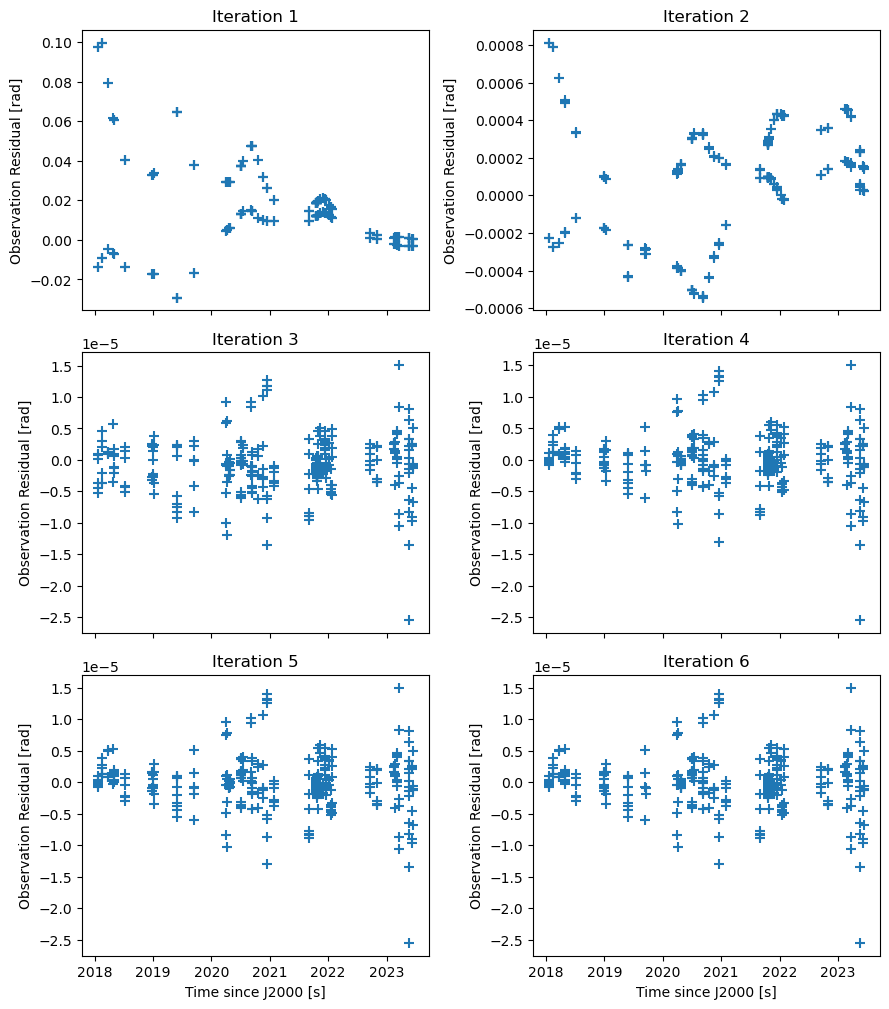

In [45]:
residual_history = pod_output.residual_history

fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=False)

# a little trick to retrieve the UTC times from the batch
times = (
    batch.table.query("observatory != 'C51'")
    .set_index("epochJ2000secondsTDB")
    .loc[observation_collection.concatenated_times]
    .epochUTC.tolist()
)

for idx, ax in enumerate(fig.get_axes()):
    ax.scatter(times, residual_history[:, idx], marker="+", s=60)
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()

axs[2, 0].set_xlabel("Time since J2000 [s]")
axs[2, 1].set_xlabel("Time since J2000 [s]")

plt.show()

The final result is within the radius of Ceres, but there is clearly plenty of room for improvement in both the dynamical model and the estimation settings.